#### Centro Universitário IESB
#### Curso de Inteligência Artificial - Turma 2021-01
#### [Disciplina de Reconhecimento de Imagens e Visão Computacional](https://classroom.google.com/u/0/c/MjcxMjMwODE3MjA3)
## Aluno: Lucas de Sousa Brito
            

# Trabalho 3

> Utilizando qualquer framework (pytorch, keras, tensorflow, fastai ...) treine uma CNN para segmentação semântica e informe a IoU média para um dataset de validação ou teste.
> Regras :
> * Pode usar o notebook da aula como ponto de partida.
> * Se optar por utilizar o notebook da aula, mude ou o dataset ou a rede neural utilizada ou os dois.
> * Pode utilizar transfer learning com os modelos pré-treinados disponibilizados pelo próprio pytorch (exceto o utilizado durando a aula).
> ADENDO: se for utilizar o notebook da aula como ponto de partida, e mantiver o dataset VOC 2012, utilizar uma rede diferente da fcn_resnet50, fcn_resnet101... pois para este dataset não é preciso fazer alteração na saída dessas redes.

# Comentários do aluno:

* Usei o notebook da aula;
* Mantive o dataset e mudei o modelo;
* Adicionei comentários iniciados por #L2: explicando boa parte do código para demonstrar que entendi o que o código faz. 
* Também criei uma nova função para definir as cores de cada classe. 

In [ ]:
# https://medium.com/analytics-vidhya/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
# https://pytorch.org/vision/stable/datasets.html#voc
# https://github.com/pytorch/vision/issues/1263
# https://pytorch.org/vision/0.8/transforms.html
# https://pillow.readthedocs.io/en/stable/reference/Image.html
# https://discuss.pytorch.org/t/how-to-use-custom-image-transformations-with-torchvision/71469
# http://host.robots.ox.ac.uk/pascal/VOC/voc2012/segexamples/index.html
# https://stackoverflow.com/questions/49338166/python-intersection-over-union
# https://pytorch.org/hub/pytorch_vision_fcn_resnet101/
# https://sparrow.dev/pytorch-normalize
# https://pytorch.org/vision/stable/models.html

In [1]:

import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pprint
import cv2
import torch.optim as optim

In [2]:
# L2: Esta classe serve para redimensionar e limpar a máscara 
def bloco():

    global trainset, validset, classes

    class MaskTransform:
        def __init__(self, size):
            """Desired dimensions as a tuple of the form (height, width)"""
            self.size = size[::-1] # PIL : (width,height), torch : (height,width)

        def __call__(self, pic):
            # L2: Redimensiona usando nearest para não borrar a máscara e confundir as classes
            res = np.array(pic.resize(self.size, Image.NEAREST))
            # L2: Ajuste de número inválido, limpeza.
            res[res==255]=0 # void/unlabeled -> background        
            return torch.as_tensor(res, dtype=torch.int64)

        def __repr__(self):
            return self.__class__.__name__ + '(size={0})'.format(self.size)

    target_transform = MaskTransform((224,224))

    # L2: esta transformação será aplicada as imagens na carga do dataset. 
    transform = transforms.Compose([    
        # L2: redimensiona para 224x224
        transforms.Resize((224,224)),
        # L2: converte para tensor
        transforms.ToTensor(),
        # L2: converte x = (x - mean) / std. Neste caso vai resultar em tensores com os pixels próximos a -0.5 a +0.5
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])


    trainset = torchvision.datasets.VOCSegmentation(root ='./data', year = '2012', image_set = 'train', 
                                                    download = True, 
                                                    #download = False, 
                                                    transform=transform, 
                                                    target_transform=target_transform
    )

    validset = torchvision.datasets.VOCSegmentation(root ='./data', year = '2012', image_set = 'val', 
                                                download = True, 
                                                #download = False, 
                                                transform=transform, 
                                                target_transform=target_transform
    )



    classes = ["background","aeroplane", "bicycle", "bird", "boat", "bottle", 
    "bus", "car" , "cat", "chair", "cow", "diningtable", 
    "dog", "horse", "motorbike", "person", "potted plant", 
    "sheep", "sofa", "train", "tv/monitor"]

    len(trainset),len(validset)

    global batch_size, train_dl, valid_dl

    # L2: Prepara os data loaders
    batch_size = 4

    train_dl = torch.utils.data.DataLoader(
        trainset, 
        batch_size=batch_size,
        shuffle=True, 
        num_workers=2
    )

    valid_dl = torch.utils.data.DataLoader(
        validset, 
        batch_size=batch_size,
        shuffle=False, 
        num_workers=2
    )

bloco()

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [4]:
def bloco():

    import matplotlib
    import matplotlib.cm
    import numpy

    global colors

    def cor(i,c):
        if i%3 == 0: 
            sat = 127
            brilho = 127
        elif i%3 == 1: 
            sat = 63
            brilho = 96
        else: 
            sat = 0
            brilho = 64

        return [int(c[0]*brilho+sat),int(c[1]*brilho+sat/2),int(c[2]*brilho+sat/2)]

    hsv = matplotlib.cm.get_cmap('hsv',len(classes))
    colors = [cor(i,hsv(i/20.0)) for i in range(20)]
    colors.insert(0,[0,0,0])

bloco()

def mask2img(t):
    t = t.unsqueeze(1).repeat((1, 3,1,1))
    for im in range(t.shape[0]):
        for rw in range(t.shape[2]):
            for cl in range(t.shape[3]):
                color_index = t[im,0,rw,cl]
                color = colors[color_index]
                t[im,:,rw,cl] = torch.tensor(color).int()
    return t,colors

In [ ]:

#def mask2img(t):
#    t = t.unsqueeze(1).repeat((1, 3,1,1))
#    v,s,h=np.meshgrid([127,190,255],[100,255],np.arange(6)*(127/6)) 
#    colors=np.vstack([h.reshape(-1),s.reshape(-1),v.reshape(-1)]).astype(np.uint8).T
#    for im in range(t.shape[0]):
#        for rw in range(t.shape[2]):
#            for cl in range(t.shape[3]):
#                color = cv2.cvtColor(colors[t[im,0,rw,cl]].reshape(1,1,-1),cv2.COLOR_HSV2RGB)
#                t[im,:,rw,cl] = torch.tensor(color).int()
#    return t,colors

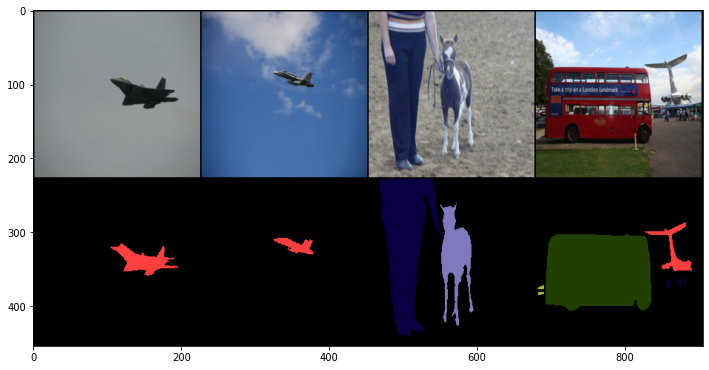

In [7]:
import matplotlib.pyplot as plt
import numpy as np

# L2: desfaz a normalização para apresentar as imagens
def undo_normalization(img):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])
    img = img * STD[:, None, None] + MEAN[:, None, None]
    return (255*img).int()

# L2: convere os canais do pytorch para o pyplot
def imshow(img):
    npimg = img.numpy()    
    # L2: isto é necessário pois no pytorch a imagem deve estar no shape (3,224,224) (cores,altura,largura) quando o pyplot espera (224,224,3) (altura,largura,cores)
    plt.figure(figsize=(12,12*8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# L2: pega uma amostra de imagens
# L2: como o conjunto de treinamento foi embaralhado (shuffle), esta saída é uma amostra aleatória das imagens
dataiter = iter(train_dl)
images, labels = dataiter.next()

# show images
imshow(
    torchvision.utils.make_grid(
        torch.cat([
                undo_normalization(images),
                mask2img(labels)[0]
            ],
            axis=0
        ),
        scale_each=2,
        nrow=4
    )  
)


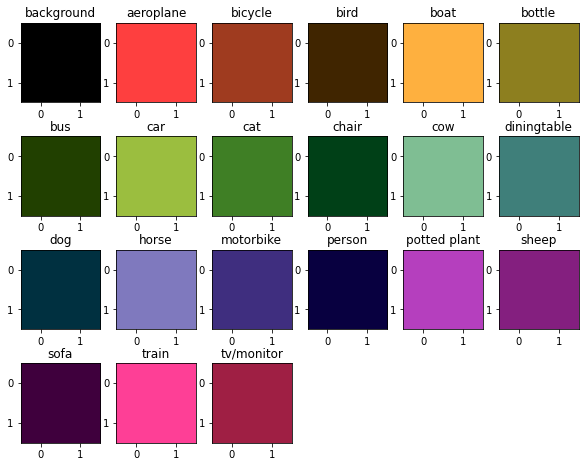

In [23]:
def run():

    # L2: cria uma imagem de 100x100 com todos os pixels da classe
    palette = torch.zeros((len(classes),2,2))   
    for i in range(len(classes)):
        palette[i,:,:] = i

    # L2: imprime as imagens de exemplo
    palette,hsv_palette = mask2img(palette.int())
    palette = palette.permute(0,2,3,1)

    plt.figure(figsize=(10,8))
    for k in range(len(classes)):
        plt.subplot(4,6,k+1)
        plt.title(classes[k])
        # plt.title(hsv_palette[k].tolist())
        plt.imshow(palette[k])

run()

In [37]:
import time

# L2: treinamento do modelo
def train(model, device, train_dl, valid_dl, loss_fn, optimizer, metric_fn, epochs=1):

    #L2: manda o modelo para a GPU
    model.to(device)

    train_loss, valid_loss = [], []
    train_metric, valid_metric = [], []

    #L2: para cada época
    for epoch in range(epochs):

        time.sleep(3)

        for phase in ['train', 'valid']:

            # L2: seleciona o conjunto de dados de acordo com a fase (train|valid)
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_metric = 0.0

            samples = 0
            # iterate over data
            for x, y in dataloader:

                x = x.to(device)
                y = y.to(device)
                
                samples += x.shape[0]

                # forward pass
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(x)["out"]
                    loss = loss_fn(outputs, y)
                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        outputs = model(x)["out"]
                        loss = loss_fn(outputs, y.long())

                metric = metric_fn(outputs, y)

                running_metric  += metric*x.shape[0]
                running_loss += loss*x.shape[0]

            print("finished {} epoch with {} samples".format(phase,samples))

            epoch_loss = running_loss / samples
            epoch_metric = running_metric / samples

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_metric.append(epoch_metric) if phase=='train' else valid_metric.append(epoch_metric)

        print(
            'Epoch: {}/{} Train Loss: {:.4f} Train Metric: {:.4f} Val Loss: {:.4f} Val Metric: {:.4f}'.format(
            epoch,epochs-1,train_loss[-1],train_metric[-1],valid_loss[-1],valid_metric[-1]))

    return train_loss, valid_loss    


In [38]:
# L2: transforma o canal de cor da imagem em uma representação one-hot. 
# L2: one-hot: transforma 1 em [0,1,0,0,0,...] 2 em [0,0,1,0,0,0...] 3 em [0,0,0,0,1,0,0,0...]
def one_hot_encode(y, n_classes):
    one_hot = torch.zeros((np.prod(y.shape),n_classes))
    for i in range(n_classes):
        vec = torch.zeros((n_classes))
        vec[i] = 1
        one_hot[y.view(-1)==i] = vec
    return one_hot.view(y.shape[0],y.shape[1],y.shape[2],n_classes).permute(0,3,1,2)

In [39]:
# L2: calcula a métrica IOU dado um conjunto de saídas e um conjunto de máscaras originais
# L2: esta métrica representa a "intersecção sobre a união", ou seja count([mascara1 e mascara2]) dividido por count([mascara1 ou mascara2])
class IouMetric:

    def __init__(self, n_classes):
        self.n_classes = n_classes

    # L2: outputs = imagens de saída do modelo
    # L2: y = imágens da máscara original
    def __call__(self,outputs, y):

        # L2: aplica o one-hot as imagens de saída
        pred = one_hot_encode(torch.nn.functional.softmax(outputs,dim=1).argmax(axis=1),self.n_classes)

        # L2: aplica o one-hot na máscara original
        y = one_hot_encode(y,self.n_classes)

        # L2: Calcula a intersecão (onde os valores são iguais nas duas máscaras)
        intersection = torch.sum(torch.logical_and(pred, y),axis=(2,3) )

        # L2: Calcula a união (onde qualquer máscara tem 1)
        union = torch.sum(torch.logical_or(pred, y),axis=(2,3))

        batch_iou = []
        for b in range(y.shape[0]):
            class_iou = []
            for c in range(self.n_classes):
                if union[b,c] != 0:
                    class_iou.append(intersection[b,c]/union[b,c])
            batch_iou.append(sum(class_iou)/len(class_iou))

        iou_score = sum(batch_iou)/len(batch_iou)

        return iou_score


In [40]:
def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [41]:
# L2: o outro modelo
#from torchvision.models.segmentation import fcn_resnet50
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large

In [42]:
#fcn = fcn_resnet50(pretrained=True, num_classes=21)

# L2: As mobilenet suportam qualquer tamanho de entrada acima de 32x32, portanto eu mantive o tamanho usado nos testes
fcn = deeplabv3_mobilenet_v3_large(pretrained=True,num_classes=21)

In [43]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [44]:
loss_fn = torch.nn.CrossEntropyLoss()

In [45]:
optimizer = optim.Adam(fcn.parameters(), lr=1e-7)

In [46]:
# treinamento
train_loss, valid_loss = train(fcn, device, train_dl, valid_dl, loss_fn, optimizer, IouMetric(21), epochs=80)

finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 0/79 Train Loss: 0.7873 Train Metric: 0.4119 Val Loss: 0.5225 Val Metric: 0.5309
finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 1/79 Train Loss: 0.7903 Train Metric: 0.4116 Val Loss: 0.5248 Val Metric: 0.5241
finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 2/79 Train Loss: 0.7593 Train Metric: 0.4107 Val Loss: 0.5210 Val Metric: 0.5272
finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 3/79 Train Loss: 0.7457 Train Metric: 0.4146 Val Loss: 0.5348 Val Metric: 0.5275
finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 4/79 Train Loss: 0.7451 Train Metric: 0.4169 Val Loss: 0.5223 Val Metric: 0.5283
finished train epoch with 1464 samples
finished valid epoch with 1449 samples
Epoch: 5/79 Train Loss: 0.7384 Train Metric: 0.4178 Val Loss: 0.5145 Val Metric: 0.5286
fini

In [ ]:
temp_iter = iter(valid_dl)

In [ ]:

xb,yb=next(temp_iter)
outputs = fcn.to(device).eval()(xb.to(device))["out"]

imshow(torchvision.utils.make_grid(
    torch.cat(
        [undo_normalization(xb.cpu()),
        mask2img(torch.nn.functional.softmax(outputs,dim=1).argmax(axis=1).cpu())[0]
    ],axis=0),nrow=4))

In [ ]:
# L2: faz o score da base de validação

iou = IouMetric(21)
r = []

for (xb,yb) in valid_dl:
    outputs = fcn.to(device).eval()(xb.to(device))["out"]
    r.append( iou(outputs,yb) )

# L2: estou assumindo que a propriedade distributiva se aplica ao IOU e a média dos batches é a mesma coisa que tomar o indicador pelo conjunto todo.
print( f'iou: {np.mean(r)}' )


